In [1]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

В мире современных социальных сетей важно не просто наполнять ленты контентом, но и
связывать его с интересами пользователей, находя взаимосвязи между постами. Грамотно
настроенный механизм сопоставления контента улучшает персональные рекомендации,
что повышает вовлечённость пользователей и обогащает их опыт.

В рамках данного соревнования вам предстоит разработать модель, которая определит,
насколько два поста близки по смыслу и релевантны друг другу. Это могут быть не только
схожие публикации, но и те, которые частично совпадают по содержанию, затрагивают
одну тему под разными углами или вовсе не связаны между собой.

Данные

Задача состоит в том, чтобы на основании заголовка и текста постов классифицировать
пары по одной из категорий, для которых степень релевантности выглядит следующим
образом:
```
relevant_plus > relevant > relevant_minus > no_relevant
```

# Load Data

In [4]:
# ! gdown --fuzzy "https://drive.google.com/file/d/1chUogO-RDrwu8CRSmK_qqGoR-IcCgwlv/view?usp=drive_link"
! unzip -q dzen.zip

In [5]:
import pandas as pd

df = pd.read_parquet("items.parquet")
df.head()

,authorId,content,itemId,title
0,22062724202903043,Британский кот — олицетворение невозмутимости....,1155255918526217609,"Как воспитать британского кота добрым, ласковы..."
1,5021973993129217102,Комнатные растения можно встретить в квартирах...,3466678402942852201,Вызывают судороги и смерть: пять опасных комна...
2,5843309594367696221,КОНТЕЙНЕР И БЫТОВКА Бывший в употреблении морс...,9802178366207388656,Из чего построить дачный дом? Семь доступных в...
3,4785891415385376217,Советский разведчик Аркадий Корнев с гранатой ...,5959787242217250844,Как осажденные советские солдаты в Афганистане...
4,6405657875686126019,Преимущества и недостатки оснастки и техники...,14212405135790401725,Преимущества и недостатки оснастки и техники д...


In [6]:
from textwrap import fill
print(fill(df.iloc[2].to_dict()["content"], 90))

КОНТЕЙНЕР И БЫТОВКА Бывший в употреблении морской контейнер можно купить в интернете от
100 000 рублей.   Проектов переделки в жилище там же, в сети, великое множество. Особенно
впечатляют постройки из двух-трех контейнеров с витражным остеклением. Особым обаянием
такие дома наделяет большая открытая веранда. Металлический каркас и обшивка у них очень
прочные, рассчитаны на то, чтобы их ставить друг на друга, поэтому и вы можете собрать
себе двухуровневый дом.   Поставить на фундамент, утеплить, обшить снаружи сайдингом или
деревом. Получится не просто домик для инвентаря, а полноценный загородный дом, такой
эффектный, что никто не догадается, из чего он сделан. В таком доме можно жить не только в
дачный сезон, но и круглый год. КУНГ КУНГ – Кузов Унифицированный Нормального (Нулевого)
Габарита. В послевоенные годы эти металлические кузова стали очень популярны благодаря
своему удобству, а аббревиатура кунг стала нарицательной. Эконом-вариант, если контейнер
не по карману. Его, конечно,

In [7]:
tr = pd.read_csv("train.csv")
tr.head()

,leftItemId,rightItemId,target
0,8456188648456666255,17842617327504664637,relevant_minus
1,2587705644018673303,4730919752548875048,relevant_minus
2,14440570074797857092,9007102992088629866,relevant
3,10768915202093280757,8382562539112058142,relevant
4,2799154957886243971,11333177839206244806,no_relevant


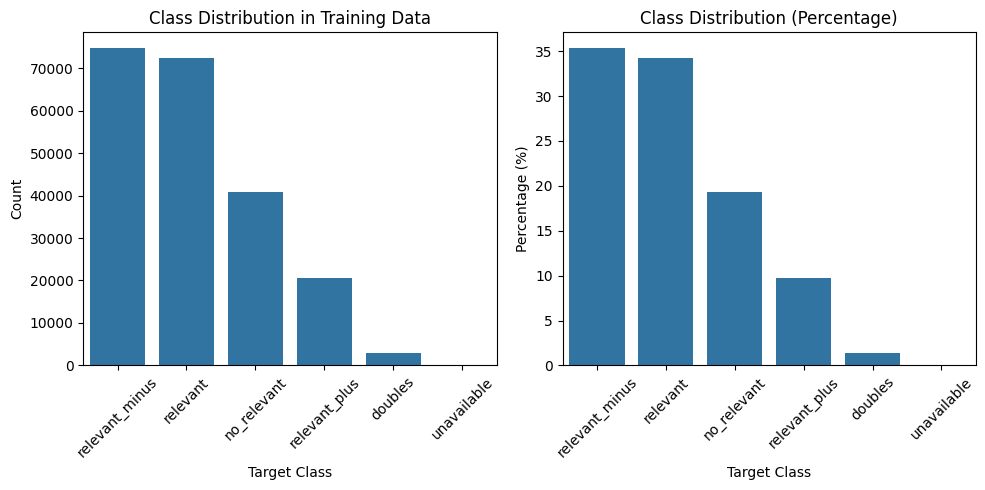

Class counts:
target
relevant_minus    74697
relevant          72436
no_relevant       40890
relevant_plus     20471
doubles            2809
unavailable          90
Name: count, dtype: int64

Class percentages:
target
relevant_minus    35.335607
relevant          34.266035
no_relevant       19.343119
relevant_plus      9.683859
doubles            1.328805
unavailable        0.042575
Name: proportion, dtype: float64


In [8]:
# Class balance analysis
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))

# Count plot
plt.subplot(1, 2, 1)
class_counts = tr['target'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution in Training Data')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Percentage plot
plt.subplot(1, 2, 2)
class_percentages = tr['target'].value_counts(normalize=True) * 100
sns.barplot(x=class_percentages.index, y=class_percentages.values)
plt.title('Class Distribution (Percentage)')
plt.xlabel('Target Class')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("Class counts:")
print(class_counts)
print("\nClass percentages:")
print(class_percentages)


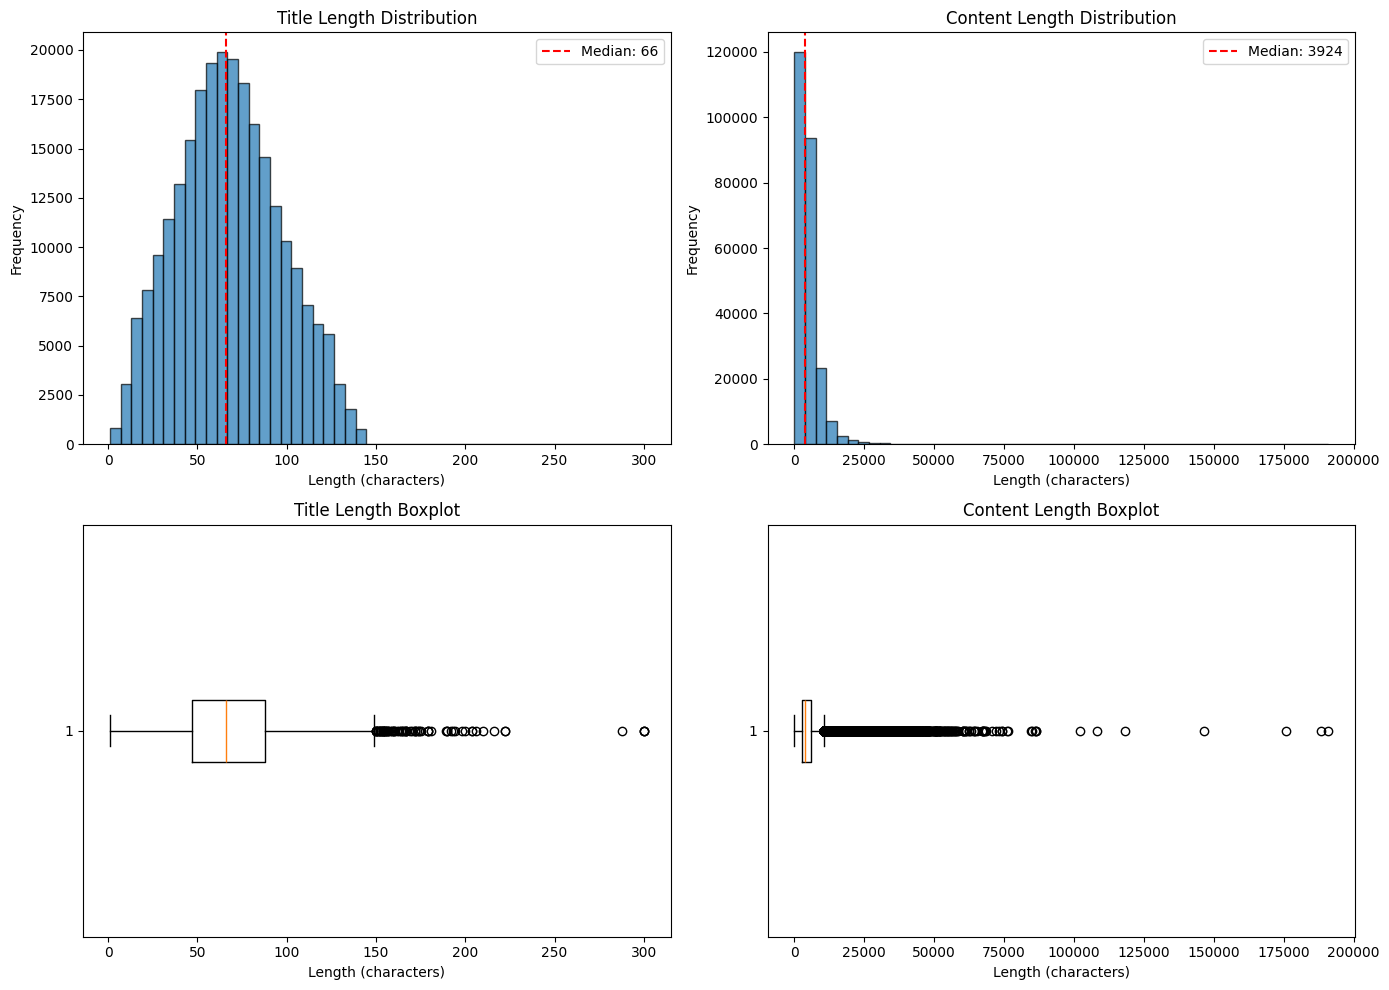

Title length statistics:
count    249451.000000
mean         67.611559
std          29.264921
min           1.000000
25%          47.000000
50%          66.000000
75%          88.000000
max         300.000000
Name: title_length, dtype: float64

Content length statistics:
count    249451.000000
mean       4901.929990
std        3925.057784
min           0.000000
25%        2665.000000
50%        3924.000000
75%        5907.000000
max      190967.000000
Name: content_length, dtype: float64


In [9]:
# Length distributions
df['title_length'] = df['title'].str.len()
df['content_length'] = df['content'].str.len()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Title length distribution
axes[0, 0].hist(df['title_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Title Length Distribution')
axes[0, 0].set_xlabel('Length (characters)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['title_length'].median(), color='red', linestyle='--', label=f'Median: {df["title_length"].median():.0f}')
axes[0, 0].legend()

# Content length distribution
axes[0, 1].hist(df['content_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Content Length Distribution')
axes[0, 1].set_xlabel('Length (characters)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df['content_length'].median(), color='red', linestyle='--', label=f'Median: {df["content_length"].median():.0f}')
axes[0, 1].legend()

# Title length boxplot
axes[1, 0].boxplot(df['title_length'], vert=False)
axes[1, 0].set_title('Title Length Boxplot')
axes[1, 0].set_xlabel('Length (characters)')

# Content length boxplot
axes[1, 1].boxplot(df['content_length'], vert=False)
axes[1, 1].set_title('Content Length Boxplot')
axes[1, 1].set_xlabel('Length (characters)')

plt.tight_layout()
plt.show()

print("Title length statistics:")
print(df['title_length'].describe())
print("\nContent length statistics:")
print(df['content_length'].describe())


In [10]:
# Item ID usage analysis
all_items = set(df['itemId'])
train_left_items = set(tr['leftItemId'])
train_right_items = set(tr['rightItemId'])
train_all_items = train_left_items | train_right_items

print(f"Total unique items in items.parquet: {len(all_items)}")
print(f"Unique items used in train (left): {len(train_left_items)}")
print(f"Unique items used in train (right): {len(train_right_items)}")
print(f"Unique items used in train (total): {len(train_all_items)}")
print(f"\nPercentage of items used in train: {len(train_all_items) / len(all_items) * 100:.2f}%")

# Check if there are items in train not in the items dataframe
items_in_train_not_in_df = train_all_items - all_items
print(f"\nItems in train not in items.parquet: {len(items_in_train_not_in_df)}")

# Check if there are items in df not used in train
items_not_used_in_train = all_items - train_all_items
print(f"Items in items.parquet not used in train: {len(items_not_used_in_train)}")


Total unique items in items.parquet: 249451
Unique items used in train (left): 120672
Unique items used in train (right): 138518
Unique items used in train (total): 216727

Percentage of items used in train: 86.88%

Items in train not in items.parquet: 0
Items in items.parquet not used in train: 32724


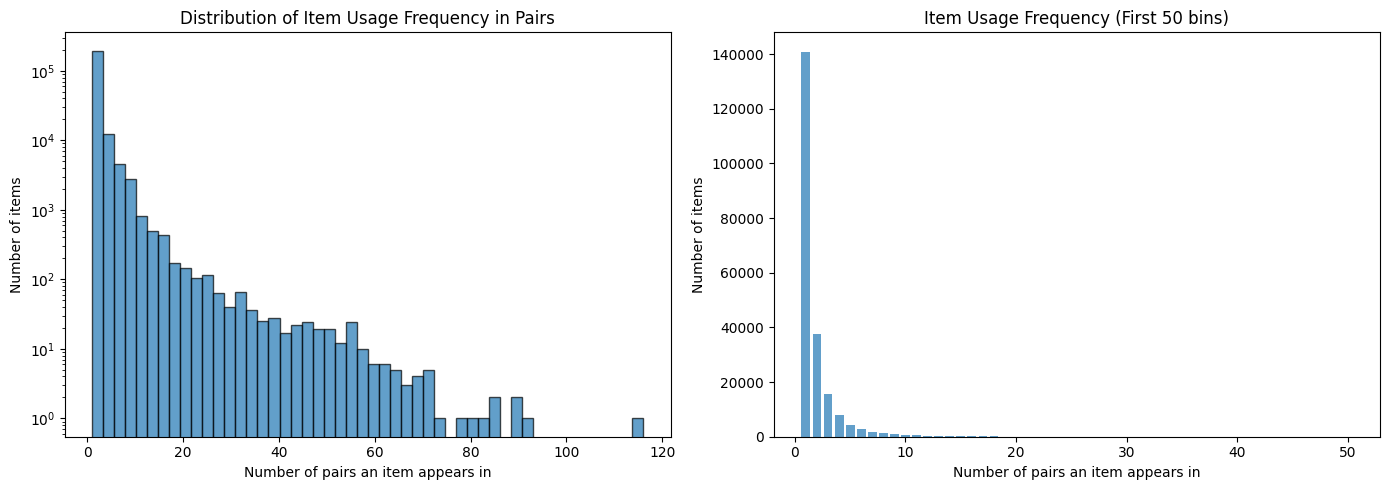

Minimum pairs per item: 1
Maximum pairs per item: 116
Mean pairs per item: 1.95
Median pairs per item: 1

Top 10 most frequently used items:
  Item 882952391163033740: appears in 116 pairs
  Item 3168819328759261068: appears in 91 pairs
  Item 12183802200932061205: appears in 90 pairs
  Item 3603716161414212099: appears in 89 pairs
  Item 11811609427722947261: appears in 86 pairs
  Item 11755758589059506681: appears in 85 pairs
  Item 6353350393004414828: appears in 82 pairs
  Item 12642797452497129729: appears in 81 pairs
  Item 14801167392792165352: appears in 77 pairs
  Item 3462976363215836717: appears in 73 pairs


In [11]:
# Item ID frequency in pairs
from collections import Counter

# Count occurrences of each item in train pairs
left_counts = Counter(tr['leftItemId'])
right_counts = Counter(tr['rightItemId'])

# Combine counts
all_counts = Counter()
for item_id in train_all_items:
    all_counts[item_id] = left_counts.get(item_id, 0) + right_counts.get(item_id, 0)

# Analyze frequency distribution
frequency_values = list(all_counts.values())

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(frequency_values, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Item Usage Frequency in Pairs')
plt.xlabel('Number of pairs an item appears in')
plt.ylabel('Number of items')
plt.yscale('log')

plt.subplot(1, 2, 2)
freq_dist = Counter(frequency_values)
top_freqs = sorted(freq_dist.items(), key=lambda x: x[0])[:50]  # Show first 50 frequency bins
plt.bar([x[0] for x in top_freqs], [x[1] for x in top_freqs], alpha=0.7)
plt.title('Item Usage Frequency (First 50 bins)')
plt.xlabel('Number of pairs an item appears in')
plt.ylabel('Number of items')

plt.tight_layout()
plt.show()

print(f"Minimum pairs per item: {min(frequency_values)}")
print(f"Maximum pairs per item: {max(frequency_values)}")
print(f"Mean pairs per item: {sum(frequency_values) / len(frequency_values):.2f}")
print(f"Median pairs per item: {sorted(frequency_values)[len(frequency_values)//2]}")

# Show top 10 most frequently used items
most_common = all_counts.most_common(10)
print("\nTop 10 most frequently used items:")
for item_id, count in most_common:
    print(f"  Item {item_id}: appears in {count} pairs")


In [12]:
# Load and analyze test data
import os

if os.path.exists('test.csv'):
    test = pd.read_csv('test.csv')
    print(f"Test data shape: {test.shape}")
    print("\nTest data head:")
    print(test.head())
    
    # Check test item IDs
    test_left_items = set(test['leftItemId'])
    test_right_items = set(test['rightItemId'])
    test_all_items = test_left_items | test_right_items
    
    print(f"\nUnique items in test (left): {len(test_left_items)}")
    print(f"Unique items in test (right): {len(test_right_items)}")
    print(f"Unique items in test (total): {len(test_all_items)}")
    
    # Overlap between train and test
    train_test_overlap = train_all_items & test_all_items
    print(f"\nItems appearing in both train and test: {len(train_test_overlap)}")
    print(f"Percentage of test items seen in train: {len(train_test_overlap) / len(test_all_items) * 100:.2f}%")
    
    # Items only in test
    only_in_test = test_all_items - train_all_items
    print(f"Items only in test (not in train): {len(only_in_test)}")
else:
    print("test.csv not found in current directory")


Test data shape: (51636, 2)

Test data head:
             leftItemId           rightItemId
0  15923600479346774213  10591191871885021601
1   7866768712250438268   9584895322191308561
2   6742770626780529612   6966853603787522235
3   4113267524593114411  16868459055811063062
4  18183962070656736836  17204657866960404813

Unique items in test (left): 39826
Unique items in test (right): 44123
Unique items in test (total): 76974

Items appearing in both train and test: 44250
Percentage of test items seen in train: 57.49%
Items only in test (not in train): 32724


In [13]:
# Inspect posts with content length > 25k characters
long_content_threshold = 25000
long_posts = df[df['content_length'] > long_content_threshold]

print(f"Posts with content length > {long_content_threshold} chars: {len(long_posts)}")
print(f"Percentage of total posts: {len(long_posts) / len(df) * 100:.2f}%\n")

left = 5

if len(long_posts) > 0:
    print("Statistics for long posts:")
    print(long_posts['content_length'].describe())
    print("\n" + "="*80 + "\n")
    
    # Show details for each long post
    for idx, row in long_posts.iterrows():
        if left == 0:
            break
        print(f"Post #{idx}")
        print(f"  Item ID: {row['itemId']}")
        print(f"  Author ID: {row['authorId']}")
        print(f"  Title length: {row['title_length']} chars")
        print(f"  Content length: {row['content_length']} chars")
        print(f"  Title: {row['title'][:100]}{'...' if len(row['title']) > 100 else ''}")
        print("  Content preview (first 200 chars):")
        print(f"    {row['content'][:200]}...")
        print("  Content preview (last 200 chars):")
        print(f"    ...{row['content'][-200:]}")
        
        # Check if this item is used in train/test
        in_train = row['itemId'] in train_all_items
        in_test = row['itemId'] in test_all_items if 'test_all_items' in locals() else False
        print(f"  Used in train: {in_train}")
        if in_train:
            print(f"    Appears in {all_counts[row['itemId']]} pairs")
        print(f"  Used in test: {in_test}")
        print("\n" + "="*80 + "\n")
        left -= 1

else:
    print("No posts with content length exceeding the threshold.")


Posts with content length > 25000 chars: 1172
Percentage of total posts: 0.47%

Statistics for long posts:
count      1172.000000
mean      34723.981229
std       13165.434449
min       25003.000000
25%       27432.250000
50%       31431.500000
75%       37616.500000
max      190967.000000
Name: content_length, dtype: float64


Post #86
  Item ID: 7203286587683239892
  Author ID: 9813851710505140936
  Title length: 78 chars
  Content length: 39413 chars
  Title: Военный эксперт Жилин: «СВО начинает стучаться в двери и окна каждой квартиры»
  Content preview (first 200 chars):
    Почему депутаты и чиновники не шагают в первых рядах мобилизации и как не платить ипотеку тем, кто сражается за Родину «Я еще в феврале предупреждал, что мы можем угодить в ловушку на востоке Украины,...
  Content preview (last 200 chars):
    ...ладимира Владимировича, потому что вопрос встанет о судьбе их детей, внуков и правнуков. И все, что им вдули в головы телевизионные Скабеевы и Соловьевы про «разбомби

In [14]:
# Inspect posts that appear in pairs more than 50 times
frequency_threshold = 50
frequent_items = {item_id: count for item_id, count in all_counts.items() if count > frequency_threshold}

print(f"Posts appearing in > {frequency_threshold} pairs: {len(frequent_items)}")
print(f"Percentage of items used in train: {len(frequent_items) / len(train_all_items) * 100:.2f}%\n")

if len(frequent_items) > 0:
    # Sort by frequency (descending)
    sorted_frequent = sorted(frequent_items.items(), key=lambda x: x[1], reverse=True)
    
    print("Distribution of these frequent items:")
    frequencies = list(frequent_items.values())
    print(f"  Min frequency: {min(frequencies)}")
    print(f"  Max frequency: {max(frequencies)}")
    print(f"  Mean frequency: {sum(frequencies) / len(frequencies):.2f}")
    print(f"  Median frequency: {sorted(frequencies)[len(frequencies)//2]}")
    print("\n" + "="*80 + "\n")
    
    # Show details for top frequent items
    for item_id, count in sorted_frequent[:3]:  # Show top 3
        # Get post details from df
        post_data = df[df['itemId'] == item_id]
        
        if len(post_data) > 0:
            post = post_data.iloc[0]
            print(f"Item ID: {item_id}")
            print(f"  Appears in {count} pairs")
            print(f"  Author ID: {post['authorId']}")
            print(f"  Title: {post['title']}")
            print(f"  Title length: {post['title_length']} chars")
            print(f"  Content length: {post['content_length']} chars")
            print("  Content preview (first 300 chars):")
            print(f"    {post['content'][:300]}...")
            
            # Analyze what relevance classes this item appears in
            left_pairs = tr[tr['leftItemId'] == item_id]
            right_pairs = tr[tr['rightItemId'] == item_id]
            all_pairs = pd.concat([left_pairs, right_pairs])
            
            print("\n  Relevance distribution for this item:")
            target_dist = all_pairs['target'].value_counts()
            for target, target_count in target_dist.items():
                print(f"    {target}: {target_count} ({target_count/len(all_pairs)*100:.1f}%)")
            
            print("\n" + "="*80 + "\n")
        else:
            print(f"Item ID {item_id}: appears in {count} pairs (NOT FOUND in items.parquet!)")
            print("="*80 + "\n")
        
        left 
    
    if len(sorted_frequent) > 3:
        print(f"... and {len(sorted_frequent) - 3} more frequent items")
else:
    print("No posts appear in more than the threshold number of pairs.")


Posts appearing in > 50 pairs: 95
Percentage of items used in train: 0.04%

Distribution of these frequent items:
  Min frequency: 51
  Max frequency: 116
  Mean frequency: 60.93
  Median frequency: 57


Item ID: 882952391163033740
  Appears in 116 pairs
  Author ID: 10614842300977517960
  Title: Блеск и ужас встречи Нового года в поезде на Петрозаводск
  Title length: 57 chars
  Content length: 10998 chars
  Content preview (first 300 chars):
    Идея поехать с семьей в путешествие поездом именно в новогоднюю ночь возникла давно. Но были и сомнения – ехать ли вообще и куда именно. В итоге выбор пал на Карелию. Веселье, лабрадор с котами, новогодний вагон-ресторан, беспокойные соседи и красивые паровозы – все это ожидало нас в поездке.  Напом...

  Relevance distribution for this item:
    no_relevant: 101 (87.1%)
    relevant_minus: 11 (9.5%)
    relevant: 4 (3.4%)


Item ID: 3168819328759261068
  Appears in 91 pairs
  Author ID: 9963866769051969857
  Title: Beluga Caviar Bar Шереметь

Total unique authors: 7762
Total posts: 249451
Average posts per author: 32.14

Posts per author statistics:
count    7762.000000
mean       32.137465
std        81.890027
min         1.000000
25%         1.000000
50%         5.000000
75%        23.000000
max      1589.000000
Name: count, dtype: float64



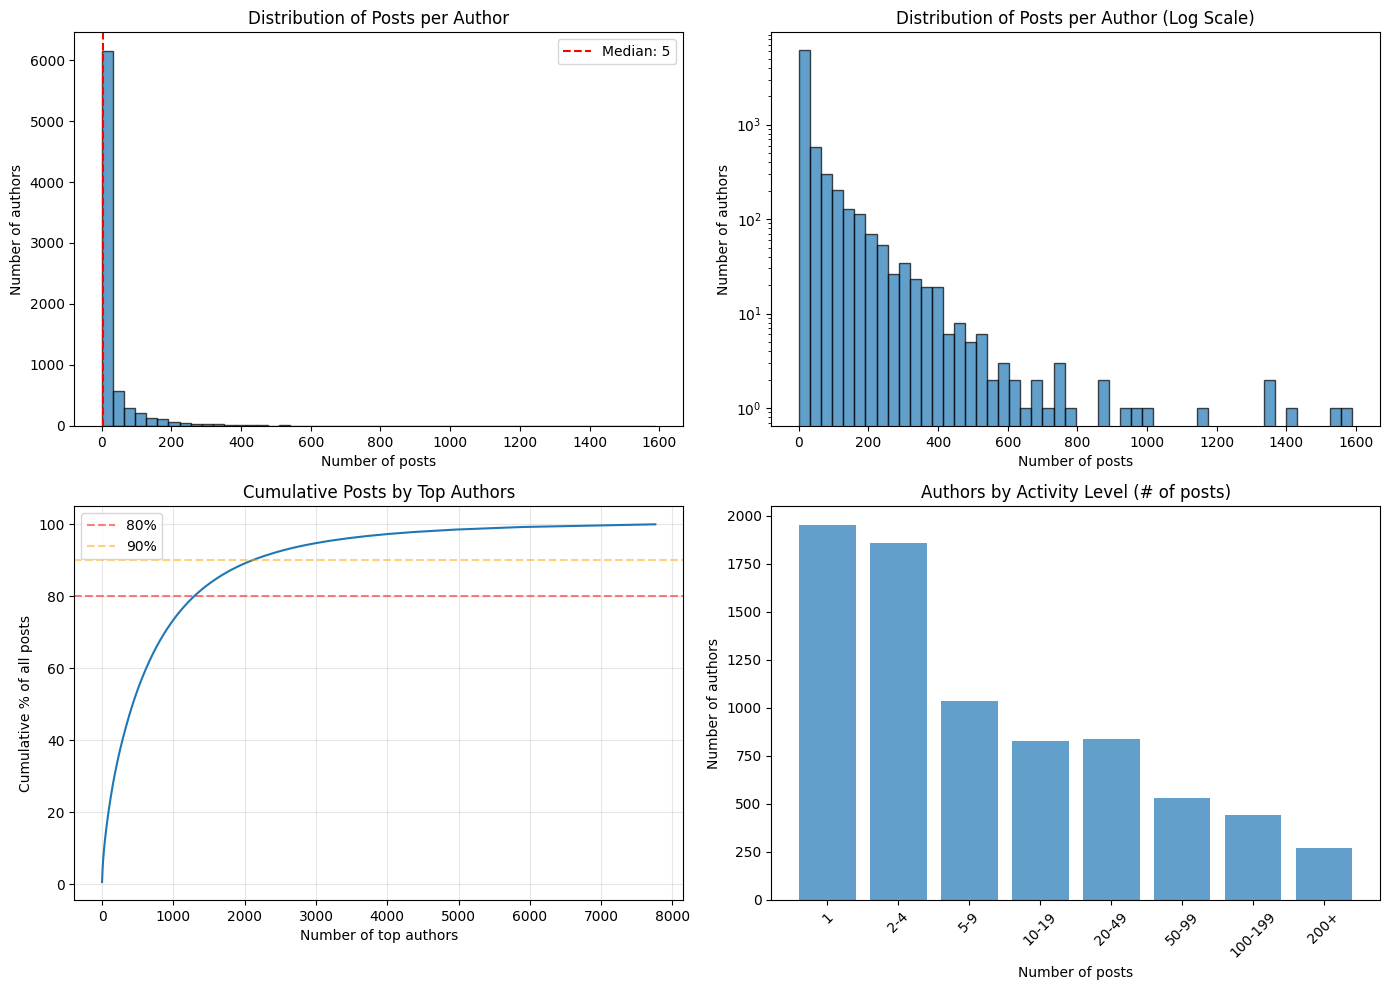


Percentiles of posts per author:
  10th percentile: 1 posts
  25th percentile: 1 posts
  50th percentile: 5 posts
  75th percentile: 23 posts
  90th percentile: 90 posts
  95th percentile: 165 posts
  99th percentile: 368 posts

Top 1292 authors (16.6%) account for 80% of all posts
Top 2108 authors (27.2%) account for 90% of all posts


In [15]:
# Author analysis

# Count unique authors
unique_authors = df['authorId'].nunique()
total_posts = len(df)

print(f"Total unique authors: {unique_authors}")
print(f"Total posts: {total_posts}")
print(f"Average posts per author: {total_posts / unique_authors:.2f}\n")

# Distribution of posts per author
posts_per_author = df['authorId'].value_counts()

print("Posts per author statistics:")
print(posts_per_author.describe())
print()

# Visualize distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram of posts per author
axes[0, 0].hist(posts_per_author.values, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Posts per Author')
axes[0, 0].set_xlabel('Number of posts')
axes[0, 0].set_ylabel('Number of authors')
axes[0, 0].axvline(posts_per_author.median(), color='red', linestyle='--', 
                    label=f'Median: {posts_per_author.median():.0f}')
axes[0, 0].legend()

# Log scale histogram
axes[0, 1].hist(posts_per_author.values, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Posts per Author (Log Scale)')
axes[0, 1].set_xlabel('Number of posts')
axes[0, 1].set_ylabel('Number of authors')
axes[0, 1].set_yscale('log')

# Cumulative distribution
sorted_posts = sorted(posts_per_author.values, reverse=True)
cumulative_posts = [sum(sorted_posts[:i+1]) for i in range(len(sorted_posts))]
cumulative_pct = [cp / total_posts * 100 for cp in cumulative_posts]
axes[1, 0].plot(range(len(cumulative_pct)), cumulative_pct)
axes[1, 0].set_title('Cumulative Posts by Top Authors')
axes[1, 0].set_xlabel('Number of top authors')
axes[1, 0].set_ylabel('Cumulative % of all posts')
axes[1, 0].grid(True, alpha=0.3)
# Mark 80% and 90% lines
axes[1, 0].axhline(80, color='red', linestyle='--', alpha=0.5, label='80%')
axes[1, 0].axhline(90, color='orange', linestyle='--', alpha=0.5, label='90%')
axes[1, 0].legend()

# Distribution of author activity levels
activity_bins = [1, 2, 5, 10, 20, 50, 100, 200, float('inf')]
activity_labels = ['1', '2-4', '5-9', '10-19', '20-49', '50-99', '100-199', '200+']
activity_counts = pd.cut(posts_per_author.values, bins=activity_bins, labels=activity_labels, right=False)
activity_dist = activity_counts.value_counts().sort_index()
axes[1, 1].bar(range(len(activity_dist)), activity_dist.values, alpha=0.7)
axes[1, 1].set_xticks(range(len(activity_dist)))
axes[1, 1].set_xticklabels(activity_dist.index, rotation=45)
axes[1, 1].set_title('Authors by Activity Level (# of posts)')
axes[1, 1].set_xlabel('Number of posts')
axes[1, 1].set_ylabel('Number of authors')

plt.tight_layout()
plt.show()

# Show percentiles
print("\nPercentiles of posts per author:")
percentiles = [10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    value = posts_per_author.quantile(p / 100)
    print(f"  {p}th percentile: {value:.0f} posts")

# Find how many authors account for 80% and 90% of posts
posts_80 = total_posts * 0.8
posts_90 = total_posts * 0.9
authors_80 = next(i+1 for i, cp in enumerate(cumulative_posts) if cp >= posts_80)
authors_90 = next(i+1 for i, cp in enumerate(cumulative_posts) if cp >= posts_90)

print(f"\nTop {authors_80} authors ({authors_80/unique_authors*100:.1f}%) account for 80% of all posts")
print(f"Top {authors_90} authors ({authors_90/unique_authors*100:.1f}%) account for 90% of all posts")


In [16]:
# Top authors details
print("Top 20 most prolific authors:\n")
print("="*80)

top_authors = posts_per_author.head(20)

for rank, (author_id, post_count) in enumerate(top_authors.items(), 1):
    author_posts = df[df['authorId'] == author_id]
    
    # Get some sample titles from this author
    sample_titles = author_posts['title'].head(3).tolist()
    
    # Check if any of this author's posts are in train
    author_items = set(author_posts['itemId'])
    items_in_train = author_items & train_all_items
    items_in_test = author_items & test_all_items if 'test_all_items' in locals() else set()
    
    print(f"{rank}. Author ID: {author_id}")
    print(f"   Posts: {post_count}")
    print(f"   Items in train: {len(items_in_train)} ({len(items_in_train)/post_count*100:.1f}%)")
    print(f"   Items in test: {len(items_in_test)} ({len(items_in_test)/post_count*100:.1f}%)")
    print(f"   Avg title length: {author_posts['title_length'].mean():.1f} chars")
    print(f"   Avg content length: {author_posts['content_length'].mean():.1f} chars")
    print("   Sample titles:")
    for i, title in enumerate(sample_titles, 1):
        print(f"     {i}. {title[:80]}{'...' if len(title) > 80 else ''}")
    print("="*80)


Top 20 most prolific authors:

1. Author ID: 11120158660896222880
   Posts: 1589
   Items in train: 1381 (86.9%)
   Items in test: 546 (34.4%)
   Avg title length: 68.1 chars
   Avg content length: 4665.9 chars
   Sample titles:
     1. «Дело Борисенко»: тайная исчезновения сына лидера советской Украины
     2. За что восточные ассасины приговорили Сталина к смерти
     3. Борис Пивенштейн: почему летчика, спасавшего челюскинцев, приговорили к смертной...
2. Author ID: 2352176866398567323
   Posts: 1539
   Items in train: 1305 (84.8%)
   Items in test: 461 (30.0%)
   Avg title length: 71.4 chars
   Avg content length: 5645.1 chars
   Sample titles:
     1. Семерка ненавистных: кого из российских звезд люди откровенно невзлюбили
     2. Учёные доказали, что дата нашего рождения влияет на здоровье
     3. Вагон прибыл без пассажиров: реальная история пропажи русских девушек
3. Author ID: 14145917242603071552
   Posts: 1406
   Items in train: 1259 (89.5%)
   Items in test: 539 (38.3%)
   

In [17]:
# Find closest author pairs based on post relevance

# First, create a mapping from itemId to authorId
item_to_author = df.set_index('itemId')['authorId'].to_dict()

# Add author information to train data
tr_with_authors = tr.copy()
tr_with_authors['leftAuthorId'] = tr_with_authors['leftItemId'].map(item_to_author)
tr_with_authors['rightAuthorId'] = tr_with_authors['rightItemId'].map(item_to_author)

# Remove rows where we couldn't find author info
tr_with_authors = tr_with_authors.dropna(subset=['leftAuthorId', 'rightAuthorId'])

print(f"Total pairs with author info: {len(tr_with_authors)}")
print(f"Pairs dropped due to missing author info: {len(tr) - len(tr_with_authors)}\n")

# Map target values to scores
relevance_scores = {
    'relevant_plus': 2,
    'relevant': 1,
    'relevant_minus': 0,
    'no_relevant': 0
}

tr_with_authors['relevance_score'] = tr_with_authors['target'].map(relevance_scores)

# Create canonical author pairs (ensure author1 <= author2 to avoid duplicates)
tr_with_authors['author_pair'] = tr_with_authors.apply(
    lambda row: tuple(sorted([row['leftAuthorId'], row['rightAuthorId']])),
    axis=1
)

# Group by author pairs and sum relevance scores
author_pair_scores = tr_with_authors.groupby('author_pair').agg({
    'relevance_score': 'sum',
    'target': 'count'  # number of pairs
}).rename(columns={'target': 'num_pairs'})

author_pair_scores = author_pair_scores.sort_values('relevance_score', ascending=False)

print(f"Total unique author pairs found: {len(author_pair_scores)}\n")
print("="*80)
print("Top 20 closest author pairs:\n")


Total pairs with author info: 211393
Pairs dropped due to missing author info: 0

Total unique author pairs found: 83262

Top 20 closest author pairs:



In [18]:
# Display details for top 20 author pairs
top_20_pairs = author_pair_scores.head(20)

for rank, ((author1, author2), row) in enumerate(top_20_pairs.iterrows(), 1):
    total_score = row['relevance_score']
    num_pairs = row['num_pairs']
    
    # Get posts from both authors
    author1_posts = df[df['authorId'] == author1]
    author2_posts = df[df['authorId'] == author2]
    
    # Get their pairs and relevance breakdown
    pair_mask = (
        ((tr_with_authors['leftAuthorId'] == author1) & (tr_with_authors['rightAuthorId'] == author2)) |
        ((tr_with_authors['leftAuthorId'] == author2) & (tr_with_authors['rightAuthorId'] == author1))
    )
    their_pairs = tr_with_authors[pair_mask]
    
    # Relevance distribution
    relevance_dist = their_pairs['target'].value_counts()
    
    print(f"{rank}. Author {author1} <-> Author {author2}")
    print(f"   Total relevance score: {total_score}")
    print(f"   Number of post pairs: {num_pairs}")
    print(f"   Average score per pair: {total_score / num_pairs:.2f}")
    print("   ")
    print("   Relevance breakdown:")
    for target in ['relevant_plus', 'relevant', 'relevant_minus', 'no_relevant']:
        count = relevance_dist.get(target, 0)
        pct = count / num_pairs * 100 if num_pairs > 0 else 0
        print(f"     {target}: {count} ({pct:.1f}%)")
    
    print("   ")
    print("   Author {author1}: {len(author1_posts)} posts total")
    print("     Sample titles:")
    for title in author1_posts['title'].head(2):
        print(f"       - {title[:70]}{'...' if len(title) > 70 else ''}")
    
    print(f"   Author {author2}: {len(author2_posts)} posts total")
    print("     Sample titles:")
    for title in author2_posts['title'].head(2):
        print(f"       - {title[:70]}{'...' if len(title) > 70 else ''}")
    
    print("="*80)


1. Author 4355561532571848179 <-> Author 4355561532571848179
   Total relevance score: 1093.0
   Number of post pairs: 1285.0
   Average score per pair: 0.85
   
   Relevance breakdown:
     relevant_plus: 262 (20.4%)
     relevant: 569 (44.3%)
     relevant_minus: 343 (26.7%)
     no_relevant: 106 (8.2%)
   
   Author {author1}: {len(author1_posts)} posts total
     Sample titles:
       - Как можно предать старые туфли
       - Жениться надо вовремя
   Author 4355561532571848179: 1363 posts total
     Sample titles:
       - Как можно предать старые туфли
       - Жениться надо вовремя
2. Author 7515144987822784630 <-> Author 7515144987822784630
   Total relevance score: 603.0
   Number of post pairs: 450.0
   Average score per pair: 1.34
   
   Relevance breakdown:
     relevant_plus: 226 (50.2%)
     relevant: 151 (33.6%)
     relevant_minus: 49 (10.9%)
     no_relevant: 17 (3.8%)
   
   Author {author1}: {len(author1_posts)} posts total
     Sample titles:
       - 9 смешных комик

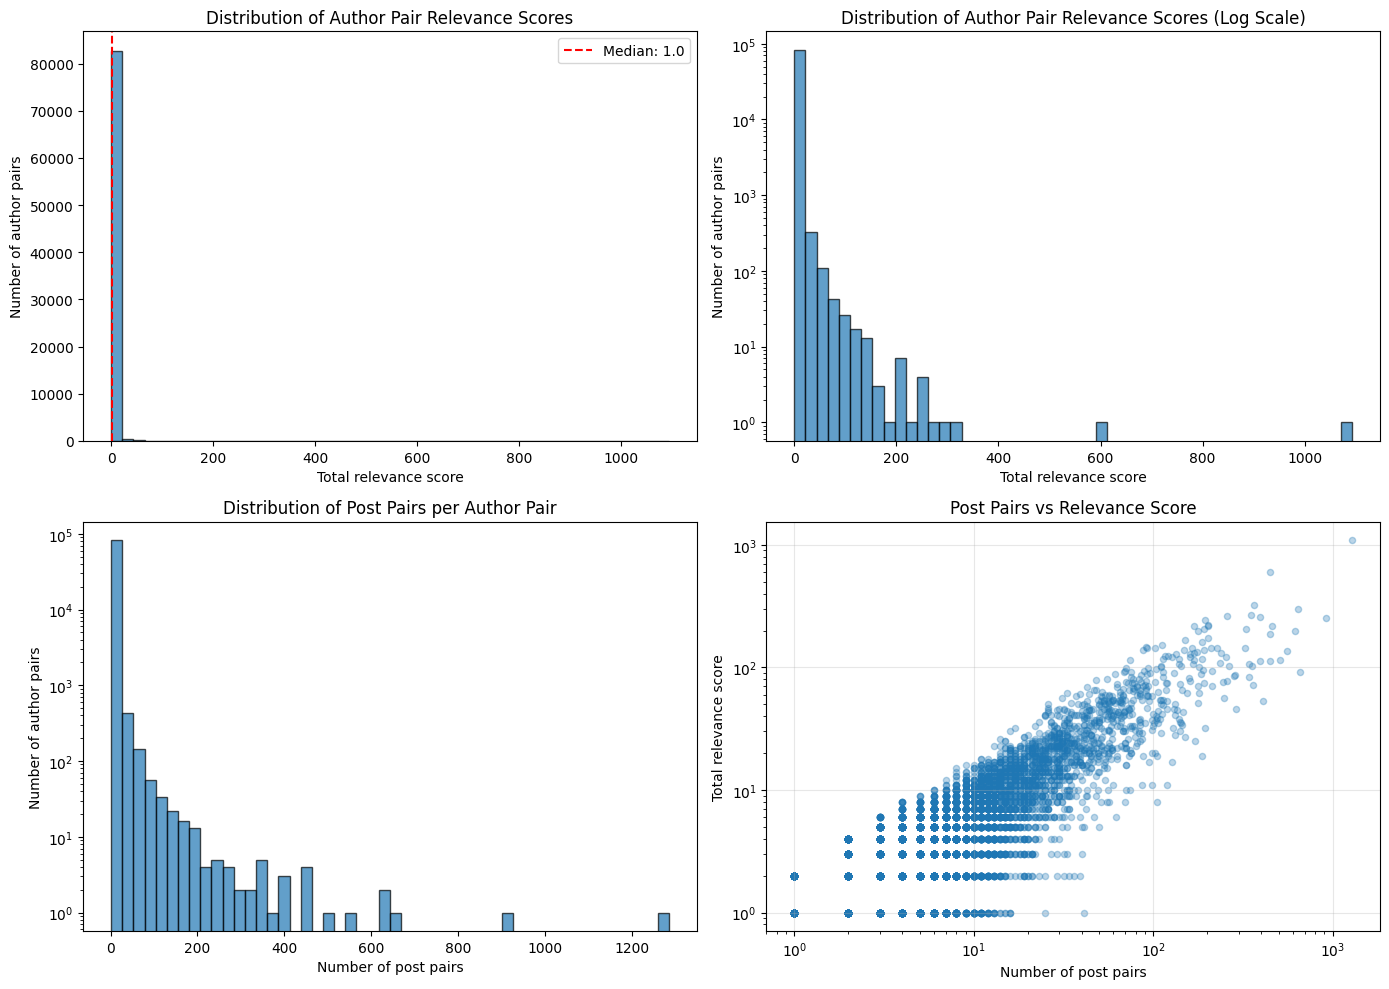

Author pair statistics:
  Total author pairs: 83262
  Mean relevance score: 1.36
  Median relevance score: 1.00
  Max relevance score: 1093
  Mean pairs per author pair: 2.54
  Median pairs per author pair: 1
  Max pairs per author pair: 1285

Author pairs with relevance score > 0: 41641 (50.0%)


In [19]:
# Visualize author pair proximity distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution of relevance scores
axes[0, 0].hist(author_pair_scores['relevance_score'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Author Pair Relevance Scores')
axes[0, 0].set_xlabel('Total relevance score')
axes[0, 0].set_ylabel('Number of author pairs')
axes[0, 0].axvline(author_pair_scores['relevance_score'].median(), color='red', 
                    linestyle='--', label=f'Median: {author_pair_scores["relevance_score"].median():.1f}')
axes[0, 0].legend()

# Log scale
axes[0, 1].hist(author_pair_scores['relevance_score'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Author Pair Relevance Scores (Log Scale)')
axes[0, 1].set_xlabel('Total relevance score')
axes[0, 1].set_ylabel('Number of author pairs')
axes[0, 1].set_yscale('log')

# Distribution of number of pairs per author pair
axes[1, 0].hist(author_pair_scores['num_pairs'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribution of Post Pairs per Author Pair')
axes[1, 0].set_xlabel('Number of post pairs')
axes[1, 0].set_ylabel('Number of author pairs')
axes[1, 0].set_yscale('log')

# Scatter: num_pairs vs relevance_score
axes[1, 1].scatter(author_pair_scores['num_pairs'], author_pair_scores['relevance_score'], 
                   alpha=0.3, s=20)
axes[1, 1].set_title('Post Pairs vs Relevance Score')
axes[1, 1].set_xlabel('Number of post pairs')
axes[1, 1].set_ylabel('Total relevance score')
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Author pair statistics:")
print(f"  Total author pairs: {len(author_pair_scores)}")
print(f"  Mean relevance score: {author_pair_scores['relevance_score'].mean():.2f}")
print(f"  Median relevance score: {author_pair_scores['relevance_score'].median():.2f}")
print(f"  Max relevance score: {author_pair_scores['relevance_score'].max():.0f}")
print(f"  Mean pairs per author pair: {author_pair_scores['num_pairs'].mean():.2f}")
print(f"  Median pairs per author pair: {author_pair_scores['num_pairs'].median():.0f}")
print(f"  Max pairs per author pair: {author_pair_scores['num_pairs'].max():.0f}")

# Pairs with score > 0
positive_score_pairs = author_pair_scores[author_pair_scores['relevance_score'] > 0]
print(f"\nAuthor pairs with relevance score > 0: {len(positive_score_pairs)} ({len(positive_score_pairs)/len(author_pair_scores)*100:.1f}%)")


решение 1:
- сравнение только заголовков
- мультиномиальный логрег над конкатенацией эмбедингов из sentence transformers

решение 2:
- обучить свои sentence эмбединги на lstm
- брать последний hidden state как признаковое описание предложения
- обучать линейный слой классификации над конкатенацией двух эмбедингов

решение 3:
- использовать TextCNN (несколько сверток разных размеров + max pool + linear projection = эмбединг предложения)
- обучать линейный слой классификации над конкатенацией двух эмбедингов

решение 3:
- обучить w2v из gensim
- усреднение эмбедингов токенов = эмбединг предложения
- мультиномиальный логрег над конкатенацией эмбедингов

# Solutions

## Baseline Implementation

Baseline approach:
- Compare only titles
- Multinomial Logistic Regression with concatenated bi-encoder embeddings
- Model: multilingual-e5-large


In [20]:
# Step 1: Filter training data and create train/val split
from sklearn.model_selection import train_test_split

relevance_classes = ['relevant_plus', 'relevant', 'relevant_minus', 'no_relevant']
tr_filtered = tr[tr['target'].isin(relevance_classes)].copy()

print(f"Original training size: {len(tr)}")
print(f"Filtered training size: {len(tr_filtered)}")
print("\nClass distribution after filtering:")
print(tr_filtered['target'].value_counts())
print("\nClass distribution (%):")
print(tr_filtered['target'].value_counts(normalize=True) * 100)

# Create train/validation split (80/20)
train_df, val_df = train_test_split(
    tr_filtered,
    test_size=0.2,
    random_state=42,
    stratify=tr_filtered['target']  # Maintain class distribution
)

print(f"\n{'='*60}")
print("Train/Validation Split:")
print(f"  Train size: {len(train_df):,}")
print(f"  Validation size: {len(val_df):,}")
print("\nTrain class distribution:")
print(train_df['target'].value_counts())
print("\nValidation class distribution:")
print(val_df['target'].value_counts())


Original training size: 211393
Filtered training size: 208494

Class distribution after filtering:
target
relevant_minus    74697
relevant          72436
no_relevant       40890
relevant_plus     20471
Name: count, dtype: int64

Class distribution (%):
target
relevant_minus    35.826930
relevant          34.742487
no_relevant       19.612075
relevant_plus      9.818508
Name: proportion, dtype: float64

Train/Validation Split:
  Train size: 166,795
  Validation size: 41,699

Train class distribution:
target
relevant_minus    59757
relevant          57949
no_relevant       32712
relevant_plus     16377
Name: count, dtype: int64

Validation class distribution:
target
relevant_minus    14940
relevant          14487
no_relevant        8178
relevant_plus      4094
Name: count, dtype: int64


In [21]:
# Step 2: Load multilingual-e5-large model
from sentence_transformers import SentenceTransformer
import numpy as np
from tqdm.auto import tqdm

# Load model
print("Loading transformer model...")
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
print(f"Model loaded. Embedding dimension: {model.get_sentence_embedding_dimension()}")

# Prepare titles with E5 instruction prefix
# E5 models require "query: " or "passage: " prefix for optimal performance
df_with_prefix = df.copy()
df_with_prefix['title_with_prefix'] = 'passage: ' + df_with_prefix['title'].fillna('')

print(f"\nTotal items to encode: {len(df_with_prefix)}")


Loading transformer model...
Model loaded. Embedding dimension: 384

Total items to encode: 249451


In [22]:
# Step 3: Encode all titles in batches
print("Encoding all titles...")
batch_size = 64

# Get all titles with E5 prefix
all_titles = df_with_prefix['title_with_prefix'].tolist()

# Encode in batches with progress bar
embeddings = model.encode(
    all_titles,
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True  # L2 normalization for better cosine similarity
)

# Create item_id to embedding mapping
item_to_embedding = dict(zip(df_with_prefix['itemId'], embeddings))

print("\nEncoding complete!")
print(f"Embedding shape: {embeddings.shape}")
print(f"Sample embedding (first 10 dims): {embeddings[0][:10]}")


Encoding all titles...


Batches:   0%|          | 0/3898 [00:00<?, ?it/s]


Encoding complete!
Embedding shape: (249451, 384)
Sample embedding (first 10 dims): [-0.02200375  0.07545947  0.02693717 -0.00660339  0.04436672  0.03414366
  0.09918912 -0.00702837 -0.09072139 -0.05618991]


In [23]:
# Step 4: Create training and validation features by concatenating embeddings
print("Creating training and validation features...")

def create_pair_features(left_ids, right_ids, item_to_emb):
    """Concatenate embeddings for item pairs"""
    features = []
    for left_id, right_id in tqdm(zip(left_ids, right_ids), total=len(left_ids)):
        left_emb = item_to_emb[left_id]
        right_emb = item_to_emb[right_id]
        # Concatenate embeddings
        pair_features = np.concatenate([left_emb, right_emb])
        features.append(pair_features)
    return np.array(features)

# Create training features
print("Processing training set...")
X_train = create_pair_features(
    train_df['leftItemId'].values,
    train_df['rightItemId'].values,
    item_to_embedding
)
y_train = train_df['target'].values

# Create validation features
print("Processing validation set...")
X_val = create_pair_features(
    val_df['leftItemId'].values,
    val_df['rightItemId'].values,
    item_to_embedding
)
y_val = val_df['target'].values

print(f"\nTraining features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Unique classes: {np.unique(y_train)}")


Creating training and validation features...
Processing training set...


  0%|          | 0/166795 [00:00<?, ?it/s]

Processing validation set...


  0%|          | 0/41699 [00:00<?, ?it/s]


Training features shape: (166795, 768)
Training labels shape: (166795,)
Validation features shape: (41699, 768)
Validation labels shape: (41699,)
Unique classes: ['no_relevant' 'relevant' 'relevant_minus' 'relevant_plus']


In [24]:
# Step 5: Train LogisticRegressionCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder

print("Training LogisticRegressionCV...")

# Encode labels to integers (required for LogisticRegressionCV)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

print("Class mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {i}: {class_name}")

# Train LogisticRegressionCV with cross-validation
clf = LogisticRegressionCV(
    Cs=10,  # Number of regularization values to try
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    solver='lbfgs',
    # max_iter=1000,
    n_jobs=-1,  # Use all CPU cores
    verbose=1,
    random_state=42
)

clf.fit(X_train, y_train_encoded)

print("\nTraining complete!")
print(f"Best C value: {clf.C_}")
print(f"Cross-validation scores shape: {clf.scores_[1].shape}")
print(f"Mean CV score: {clf.scores_[1].mean():.4f}")


Training LogisticRegressionCV...
Class mapping:
  0: no_relevant
  1: relevant
  2: relevant_minus
  3: relevant_plus


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished



Training complete!
Best C value: [0.04641589 0.04641589 0.04641589 0.04641589]
Cross-validation scores shape: (5, 10)
Mean CV score: 0.3954


Evaluating on validation set...

Validation Accuracy: 0.4058

Classification Report:


/Users/voorhs/repos/sirius/sirius-ai/day_3/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/voorhs/repos/sirius/sirius-ai/day_3/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/voorhs/repos/sirius/sirius-ai/day_3/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

                precision    recall  f1-score   support

   no_relevant       0.00      0.00      0.00      8178
      relevant       0.41      0.55      0.47     14487
relevant_minus       0.40      0.60      0.48     14940
 relevant_plus       0.00      0.00      0.00      4094

      accuracy                           0.41     41699
     macro avg       0.20      0.29      0.24     41699
  weighted avg       0.29      0.41      0.34     41699



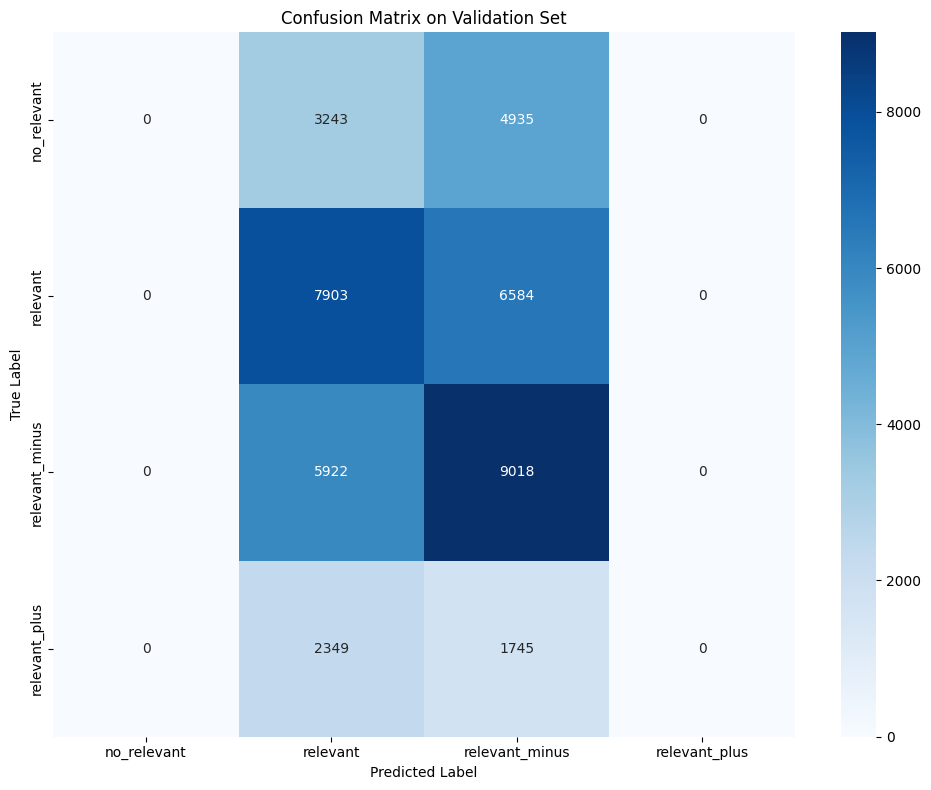

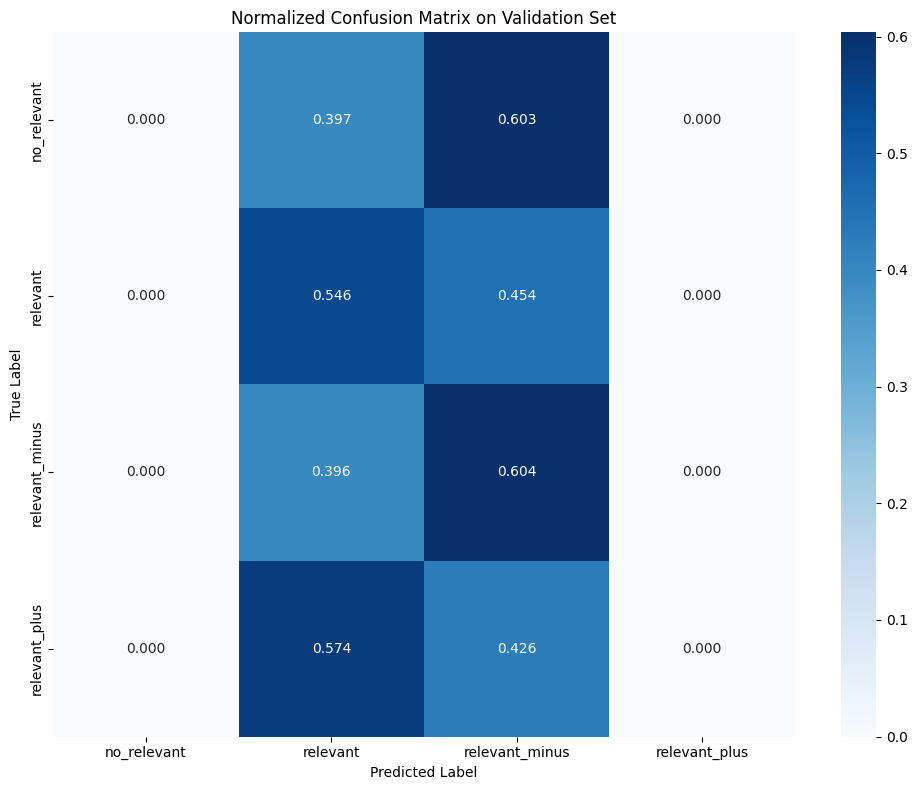

In [25]:
# Step 6: Evaluate on validation set
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

print("Evaluating on validation set...")

# Encode validation labels
y_val_encoded = label_encoder.transform(y_val)

# Predict on validation set
y_val_pred_encoded = clf.predict(X_val)
y_val_pred = label_encoder.inverse_transform(y_val_pred_encoded)

# Calculate accuracy
val_accuracy = accuracy_score(y_val_encoded, y_val_pred_encoded)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred, labels=label_encoder.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix on Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Normalized Confusion Matrix on Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


# Alternative Solutions

We will implement three additional approaches:
1. **LSTM Sentence Embeddings**: Train LSTM to encode sentences, use last hidden state
2. **TextCNN**: Multiple convolutions with different kernel sizes for sentence encoding
3. **Word2Vec + Averaging**: Train Word2Vec, average token embeddings

All approaches use a siamese architecture with concatenated embeddings.


## Data Preparation: Tokenization and Vocabulary


In [ ]:
# Simple tokenizer for Russian text
import re
from collections import Counter

def simple_tokenize(text):
    """Simple tokenization: lowercase, remove punctuation, split"""
    if pd.isna(text):
        return []
    text = text.lower()
    # Keep only letters and spaces
    text = re.sub(r'[^а-яёa-z\s]', ' ', text)
    # Split and filter empty tokens
    tokens = [t for t in text.split() if t]
    return tokens

# Test tokenizer
sample_title = df.iloc[0]['title']
print(f"Original: {sample_title}")
print(f"Tokenized: {simple_tokenize(sample_title)}")


In [ ]:
# Build vocabulary from all titles
print("Tokenizing all titles...")
all_tokens = []
for title in tqdm(df['title'].fillna(''), desc="Tokenizing"):
    all_tokens.extend(simple_tokenize(title))

print(f"\nTotal tokens: {len(all_tokens)}")

# Count token frequencies
token_counts = Counter(all_tokens)
print(f"Unique tokens: {len(token_counts)}")

# Build vocabulary with minimum frequency
MIN_FREQ = 2
vocab = {'<PAD>': 0, '<UNK>': 1}  # Special tokens
for token, count in token_counts.items():
    if count >= MIN_FREQ:
        vocab[token] = len(vocab)

print(f"Vocabulary size (min_freq={MIN_FREQ}): {len(vocab)}")
print(f"Most common tokens: {token_counts.most_common(20)}")


In [ ]:
# Function to convert text to sequence of indices
def text_to_sequence(text, vocab, max_length=50):
    """Convert text to padded sequence of token indices"""
    tokens = simple_tokenize(text)
    # Convert to indices
    indices = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    # Pad or truncate
    if len(indices) < max_length:
        indices = indices + [vocab['<PAD>']] * (max_length - len(indices))
    else:
        indices = indices[:max_length]
    return indices

# Test
sample_seq = text_to_sequence(sample_title, vocab, max_length=20)
print(f"Sequence: {sample_seq}")
print(f"Length: {len(sample_seq)}")


In [ ]:
# Create mapping from itemId to sequence
MAX_LENGTH = 50
print(f"Converting all titles to sequences (max_length={MAX_LENGTH})...")

item_to_sequence = {}
for _, row in tqdm(df.iterrows(), total=len(df), desc="Converting"):
    item_to_sequence[row['itemId']] = text_to_sequence(row['title'], vocab, MAX_LENGTH)

print(f"Total items converted: {len(item_to_sequence)}")

# Verify conversion
sample_item_id = df.iloc[0]['itemId']
print(f"Sample sequence for item {sample_item_id}: {item_to_sequence[sample_item_id][:10]}...")


## Solution 2: LSTM Sentence Embeddings


In [ ]:
# TODO

## Solution 3: TextCNN


In [ ]:
# TODO

## Solution 4: Word2Vec + Averaging


In [ ]:
# TODO